**Basic Time Series Analysis on Cryptocurrency Historical Prices**

In [1]:
import numpy as np 
import pandas as pd 
import os
#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))



In [2]:

import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
from pandas import DataFrame
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [3]:
df = pd.read_csv('ethereum_price.csv')
df.head(3)

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Aug 07, 2017",261.24,271.96,256.69,269.18,"935,727,000","24,511,000,000"
1,"Aug 06, 2017",256.42,271.05,252.85,261.57,"1,482,980,000","24,053,500,000"
2,"Aug 05, 2017",222.85,256.51,221.95,256.51,"1,333,000,000","20,900,000,000"


In [4]:
print (df.describe())


             Open        High         Low       Close
count  732.000000  732.000000  732.000000  732.000000
mean    39.138098   41.261176   37.085668   39.493305
std     79.033720   83.155622   74.491504   79.492491
min      0.431589    0.482988    0.420897    0.434829
25%      2.735000    3.005000    2.507500    2.722500
50%     10.930000   11.205000   10.555000   10.945000
75%     13.992500   14.452500   13.425000   14.005000
max    397.590000  414.760000  370.060000  401.490000


In [5]:
print (df.dtypes)

Date           object
Open          float64
High          float64
Low           float64
Close         float64
Volume         object
Market Cap     object
dtype: object


In [6]:
df1 = df[['Date','Close']]
df1.head(3)

,Date,Close
0,"Aug 07, 2017",269.18
1,"Aug 06, 2017",261.57
2,"Aug 05, 2017",256.51


In [7]:
# Setting the Date as Index
df_ts = df1.set_index('Date')
df_ts.sort_index(inplace=True)
print (type(df_ts))
print (df_ts.head(3))
print (df_ts.tail(3))

<class 'pandas.core.frame.DataFrame'>
              Close
Date               
Apr 01, 2016  11.66
Apr 01, 2017  50.70
Apr 02, 2016  11.60
                  Close
Date                   
Sep 29, 2016  13.070000
Sep 30, 2015   0.738644
Sep 30, 2016  13.220000


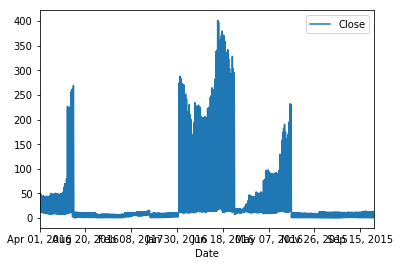

In [8]:
#plot
df_ts.plot()

In [9]:
# Dickey Fuller Test Function
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    from statsmodels.tsa.stattools import adfuller
    print('Results of Dickey-Fuller Test:')
       
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

In [11]:
# Stationarity with Dickey Fuller Test 
# Convert the DF to series first
ts = df_ts['Close']
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -2.659276
p-value                          0.081354
#lags Used                       4.000000
Number of Observations Used    727.000000
Critical Value (1%)             -3.439377
Critical Value (5%)             -2.865524
Critical Value (10%)            -2.568891
dtype: float64


**Conclusion??**

The Test Statistics value is Much higher than critical value. So we can't reject the Null Hypothesis.

Hence from the plot the Time series is Non-Stationary

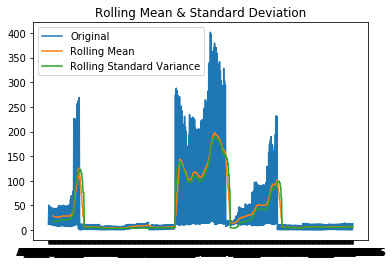

In [12]:
# plot the 12-Month Moving Rolling Mean, Variance 
# Rolling Statistics
rolmean = ts.rolling(window=12).mean()
rolvar = ts.rolling(window=12).std()

plt.plot(ts, label='Original')
plt.plot(rolmean, label='Rolling Mean')
plt.plot(rolvar, label='Rolling Standard Variance')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [13]:
# vanila decomposition to see any trend seasonality in the ts
decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative')

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

AttributeError: 'Index' object has no attribute 'inferred_freq'

**Conslusion**

Seasonal graph is too stacked . This was obvious by the way as we are analyzing daily data so trying out a Monthly approach

In [14]:
#data by Month and analyze again
df_ts_m = df_ts.resample('M').mean()
print (type(df_ts_m))
print (df_ts_m.head(3))

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [15]:
tsm = df_ts_m['Close']
print (type(tsm))

NameError: name 'df_ts_m' is not defined

In [ ]:
# Stationarity Check
test_stationarity(tsm)

In [ ]:
# A quick vanila decomposition 
decomposition = sm.tsa.seasonal_decompose(tsm, model='multiplicative')

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

**Conclusion**

Much more clear seasonality graph

In [ ]:
# "tsm" Stationary

tsmlog = np.log10(tsm)
tsmlog.dropna(inplace=True)

tsmlogdiff = tsmlog.diff(periods=1)
tsmlogdiff.dropna(inplace=True)
# Stationarity Check
test_stationarity(tsmlogdiff)

**Conclusion**

The time series is Stationary now. We can use it now in Forecasting Techniques like ARIMA

In [ ]:
# plot ACF & PACF graphs to visualize AR & MA components
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(tsmlogdiff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(tsmlogdiff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()